<a href="https://www.kaggle.com/code/shivam1298/bitcoin-price-prediction-using-rnn?scriptVersionId=120759780" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="color:red; text-align:center">Goal of this model is to predict Bitcoin prices with help of Bitcoin historical data.</h1>

**Dataset:**
1. There is 1 csv file, created from 5 different csv files. 
2. CSV files for select bitcoin exchanges for the time period of Jan 2017 to Dec 2020, with minute to minute updates of 
    * OHLC (Open, High, Low, Close)
    * Volume in BTC and indicated currency
    * Weighted bitcoin price (Volume USD).
3. Timestamps are in date variable.
4. Timestamps without any trades or activity have their data fields forward filled from the last valid time period. 
5. If a timestamp is missing, or if there are jumps, this may be because the exchange (or its API) was down, the exchange (or its API) did not exist, or some other unforseen technical error in data reporting or gathering.

<h3 style="color:brown">Importing Libraries</h3>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy


# Data Transofrmation
from sklearn.preprocessing import MinMaxScaler


# Keras & TF libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import layers


# Time Series model libraries & validation libraries
from scipy import stats
from pylab import rcParams
import statsmodels.api as sm
from itertools import product
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-poster')

<h3 style="color:brown">Reading & Analysing Data</h3>

In [2]:
df_bitcoin = pd.read_csv("/kaggle/input/bitcoin-price-2017-2021.csv")
df_bitcoin.shape

(2552241, 11)

In [3]:
df_bitcoin.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,year,date_only
0,1514764740,2017-12-31 23:59:00,BTC/USD,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549,2017,2017-12-31
1,1514764680,2017-12-31 23:58:00,BTC/USD,13913.26,13953.83,13884.69,13953.77,1.398784,19518.309658,2017,2017-12-31
2,1514764620,2017-12-31 23:57:00,BTC/USD,13908.73,13913.26,13874.99,13913.26,0.775012,10782.944294,2017,2017-12-31
3,1514764560,2017-12-31 23:56:00,BTC/USD,13827.00,13908.69,13827.00,13859.58,0.666459,9236.841134,2017,2017-12-31
4,1514764500,2017-12-31 23:55:00,BTC/USD,13825.05,13825.05,13825.05,13825.05,0.065501,905.560130,2017,2017-12-31


In [4]:
df_bitcoin.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2552241 entries, 0 to 2552240

Data columns (total 11 columns):

 #   Column      Dtype  

---  ------      -----  

 0   unix        int64  

 1   date        object 

 2   symbol      object 

 3   open        float64

 4   high        float64

 5   low         float64

 6   close       float64

 7   Volume BTC  float64

 8   Volume USD  float64

 9   year        int64  

 10  date_only   object 

dtypes: float64(6), int64(2), object(3)

memory usage: 214.2+ MB


In [5]:
df_bitcoin.describe().T

,count,mean,std,min,25%,50%,75%,max
unix,2552241.0,1.554235e+09,3.737896e+07,1.483229e+09,1.521513e+09,1.559796e+09,1.587958e+09,1.609459e+09
open,2552241.0,7.858622e+03,4.089171e+03,7.520000e+02,5.250780e+03,8.040340e+03,9.894020e+03,2.929994e+04
high,2552241.0,7.863520e+03,4.092307e+03,7.528100e+02,5.253770e+03,8.046750e+03,9.900000e+03,2.930000e+04
low,2552241.0,7.853549e+03,4.085862e+03,7.513400e+02,5.247600e+03,8.034130e+03,9.887410e+03,2.926700e+04
close,2552241.0,7.858602e+03,4.089217e+03,7.520400e+02,5.250790e+03,8.040000e+03,9.893660e+03,2.929994e+04
Volume BTC,2552241.0,6.784487e+00,1.775146e+01,0.000000e+00,2.718913e-01,1.669265e+00,6.213299e+00,1.616060e+03
Volume USD,2552241.0,5.227170e+04,1.443452e+05,0.000000e+00,1.706910e+03,1.128474e+04,4.466964e+04,1.063814e+07
year,2552241.0,2.018764e+03,1.164628e+00,2.017000e+03,2.018000e+03,2.019000e+03,2.020000e+03,2.020000e+03


**Extracting Date from date column**

In [6]:
df_bitcoin["date_only"] = df_bitcoin.date.apply(lambda x : x[:10])
df_bitcoin.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,year,date_only
0,1514764740,2017-12-31 23:59:00,BTC/USD,13913.28,13913.28,13867.18,13880.00,0.591748,8213.456549,2017,2017-12-31
1,1514764680,2017-12-31 23:58:00,BTC/USD,13913.26,13953.83,13884.69,13953.77,1.398784,19518.309658,2017,2017-12-31
2,1514764620,2017-12-31 23:57:00,BTC/USD,13908.73,13913.26,13874.99,13913.26,0.775012,10782.944294,2017,2017-12-31
3,1514764560,2017-12-31 23:56:00,BTC/USD,13827.00,13908.69,13827.00,13859.58,0.666459,9236.841134,2017,2017-12-31
4,1514764500,2017-12-31 23:55:00,BTC/USD,13825.05,13825.05,13825.05,13825.05,0.065501,905.560130,2017,2017-12-31


In [7]:
Price = pd.DataFrame(df_bitcoin.groupby('date_only')['Volume USD'].mean())
Price.shape

(1435, 1)

In [8]:
Price.head()

,Volume USD
date_only,
2017-01-01,4701.831942
2017-01-02,5747.243606
2017-01-03,6442.176792
2017-01-04,16303.129214
2017-01-05,25132.509465


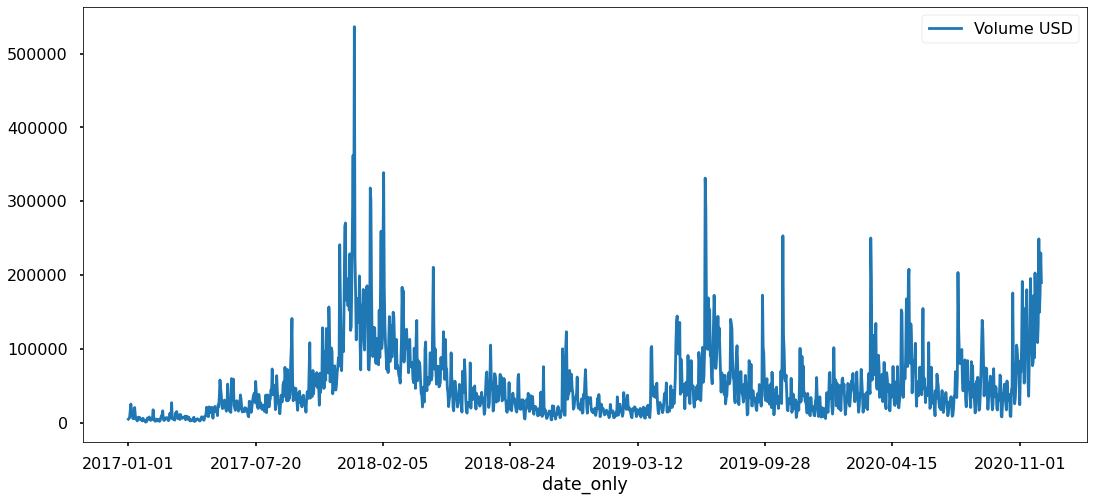

In [9]:
Price.plot(figsize=(18,8))
plt.show()

In [10]:
min(df_bitcoin.date), max(df_bitcoin.date)

('2017-01-01 00:01:00', '2020-12-31 23:59:00')

<h2 style="color:red; text-align:center">Recursive Neural Network</h2>

<h3 style="color:brown">Train/Test Split</h3>

In [11]:
# using prediction as 4 months, we're using 120 for train/test split

prediction_days = len(Price)-120

train = Price.iloc[:prediction_days]
test = Price.iloc[prediction_days:]

In [12]:
train.shape, test.shape

((1315, 1), (120, 1))

<h3 style="color:brown">Data Preprocessing</h3>

In [13]:
# Data preprocess

sc = MinMaxScaler()

sc.fit(train)

scaled_train = sc.transform(train)
scaled_test = sc.transform(test)

X_train = scaled_train[0:len(scaled_train)-1]
y_train = scaled_train[1:len(scaled_train)]

X_test = scaled_train[0:len(scaled_test)-1]
y_test = scaled_train[1:len(scaled_test)]

<h3 style="color:brown">RNN Model</h3>

**Model 1**

In [14]:
%%time

regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'relu', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 50)

Epoch 1/50

263/263 [==============================] - 2s 2ms/step - loss: 0.0105

Epoch 2/50

263/263 [==============================] - 0s 2ms/step - loss: 0.0080

Epoch 3/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0073

Epoch 4/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0064

Epoch 5/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0054

Epoch 6/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0046

Epoch 7/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0041

Epoch 8/50

263/263 [==============================] - 0s 2ms/step - loss: 0.0039

Epoch 9/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0037

Epoch 10/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0037

Epoch 11/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0037

Epoch 12/50

263/263 [==============================] - 0s 1ms/step - loss: 0.0036

E

<h3 style="color:brown">Testing the Model</h3>

In [15]:
predicted_BTC_price = regressor.predict(scaled_test)

predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

4/4 [==============================] - 0s 1ms/step


In [16]:
test["Predictions_Model1"] = predicted_BTC_price
test

,Volume USD,Predictions_Model1
date_only,,
2020-08-08,32350.849036,33246.507812
2020-08-09,21463.778842,24744.744141
2020-08-10,63531.091502,58332.558594
2020-08-11,84009.668974,75388.945312
2020-08-12,45127.330317,43394.839844
...,...,...
2020-12-27,248901.009642,185146.812500
2020-12-28,149571.375912,129557.328125
2020-12-29,177284.799030,144677.656250


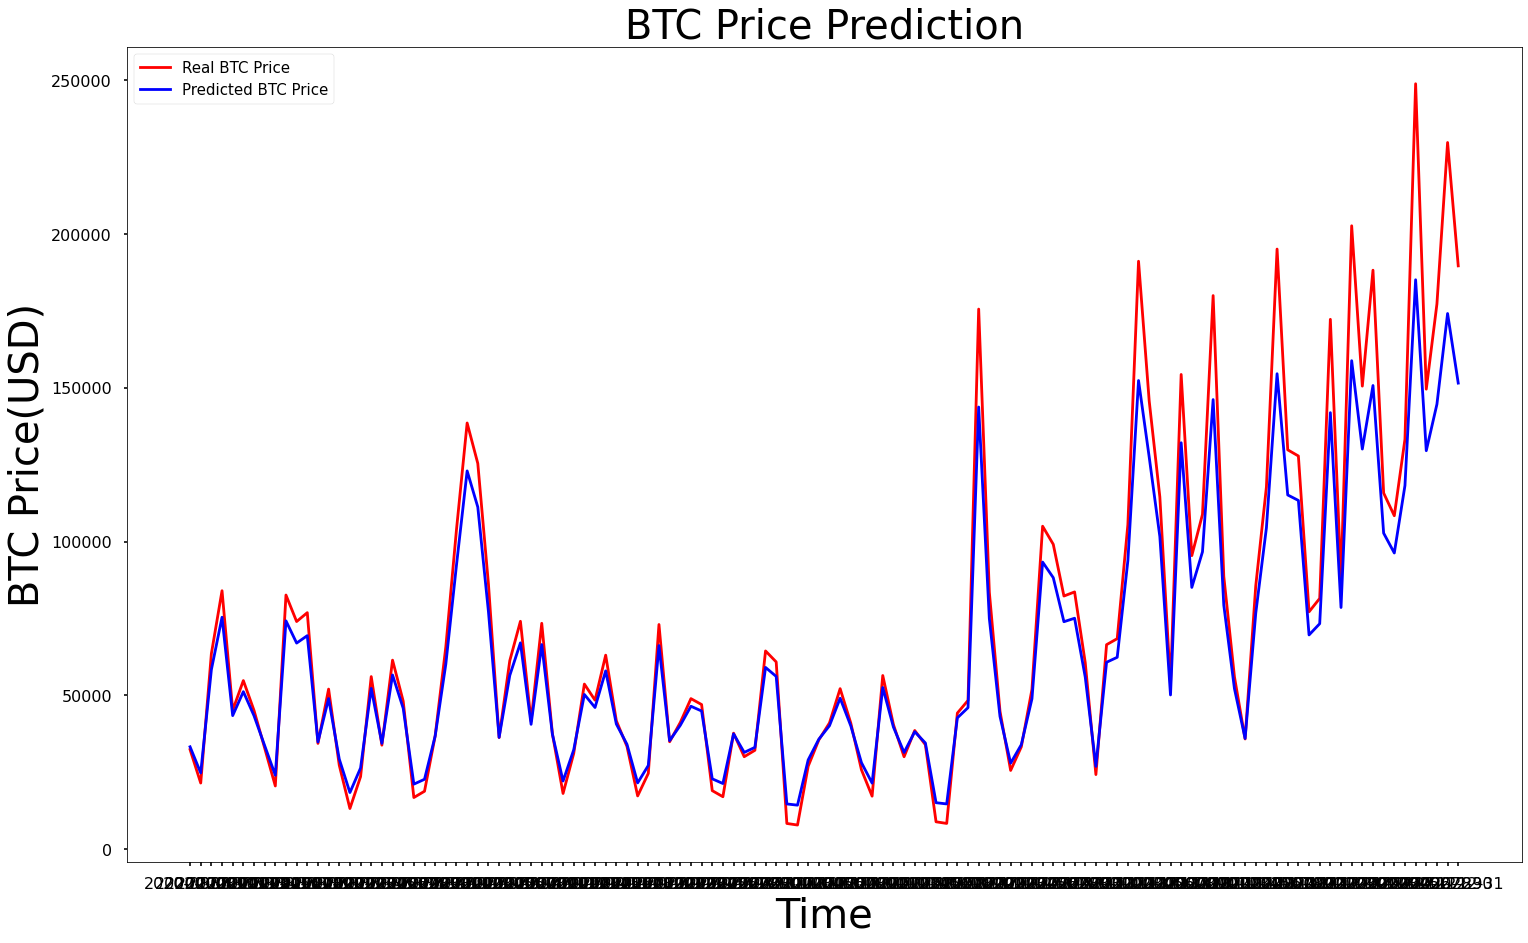

In [17]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test.reset_index()["date_only"], test.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

**Observations:** We can see similar predictions but it doesn't predict well towards the end. Let's try early stopping callback.

**Model 2**

In [18]:
early_stop = EarlyStopping(monitor='loss',patience=2)

In [19]:
%%time

regressor2 = Sequential()

# Adding the input layer and the LSTM layer
regressor2.add(LSTM(units = 128, activation = 'relu', input_shape = (None, 1)))

regressor2.add(Dense(units = 1))

regressor2.add(Dense(units = 1))

# Compiling the RNN
regressor2.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor2.fit(X_train, y_train, batch_size = 5, epochs = 50, callbacks=[early_stop])

Epoch 1/50

263/263 [==============================] - 2s 2ms/step - loss: 0.0064

Epoch 2/50

263/263 [==============================] - 1s 2ms/step - loss: 0.0038

Epoch 3/50

263/263 [==============================] - 1s 2ms/step - loss: 0.0036

Epoch 4/50

263/263 [==============================] - 0s 2ms/step - loss: 0.0036

Epoch 5/50

263/263 [==============================] - 0s 2ms/step - loss: 0.0036

Epoch 6/50

263/263 [==============================] - 1s 2ms/step - loss: 0.0036

CPU times: total: 1.75 s

Wall time: 4.52 s


<AxesSubplot:>

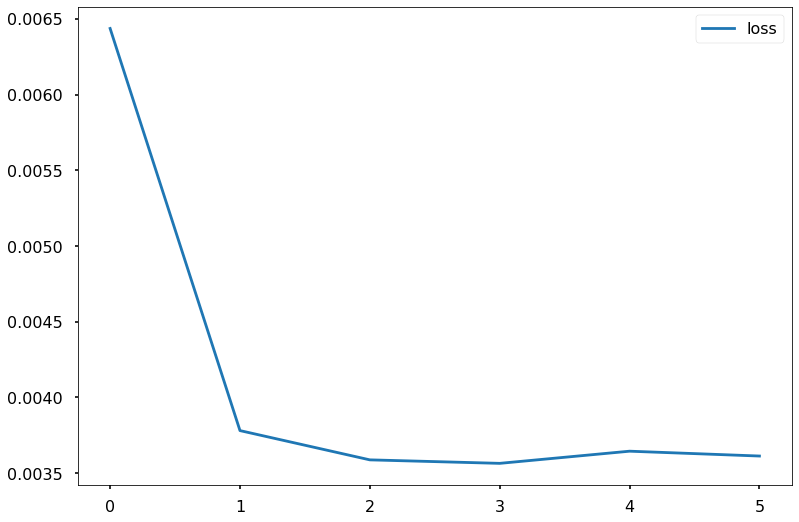

In [20]:
losses = pd.DataFrame(regressor2.history.history)
losses.plot()

<h3 style="color:brown">Testing the Model</h3>

In [21]:
predicted_BTC_price2 = regressor2.predict(scaled_test)

predicted_BTC_price2 = sc.inverse_transform(predicted_BTC_price2)

4/4 [==============================] - 0s 2ms/step


In [22]:
test["Predictions_Model2"] = predicted_BTC_price2
test

,Volume USD,Predictions_Model1,Predictions_Model2
date_only,,,
2020-08-08,32350.849036,33246.507812,36232.921875
2020-08-09,21463.778842,24744.744141,28390.945312
2020-08-10,63531.091502,58332.558594,58838.808594
2020-08-11,84009.668974,75388.945312,73804.460938
2020-08-12,45127.330317,43394.839844,45469.636719
...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250
2020-12-28,149571.375912,129557.328125,122308.351562
2020-12-29,177284.799030,144677.656250,141059.156250


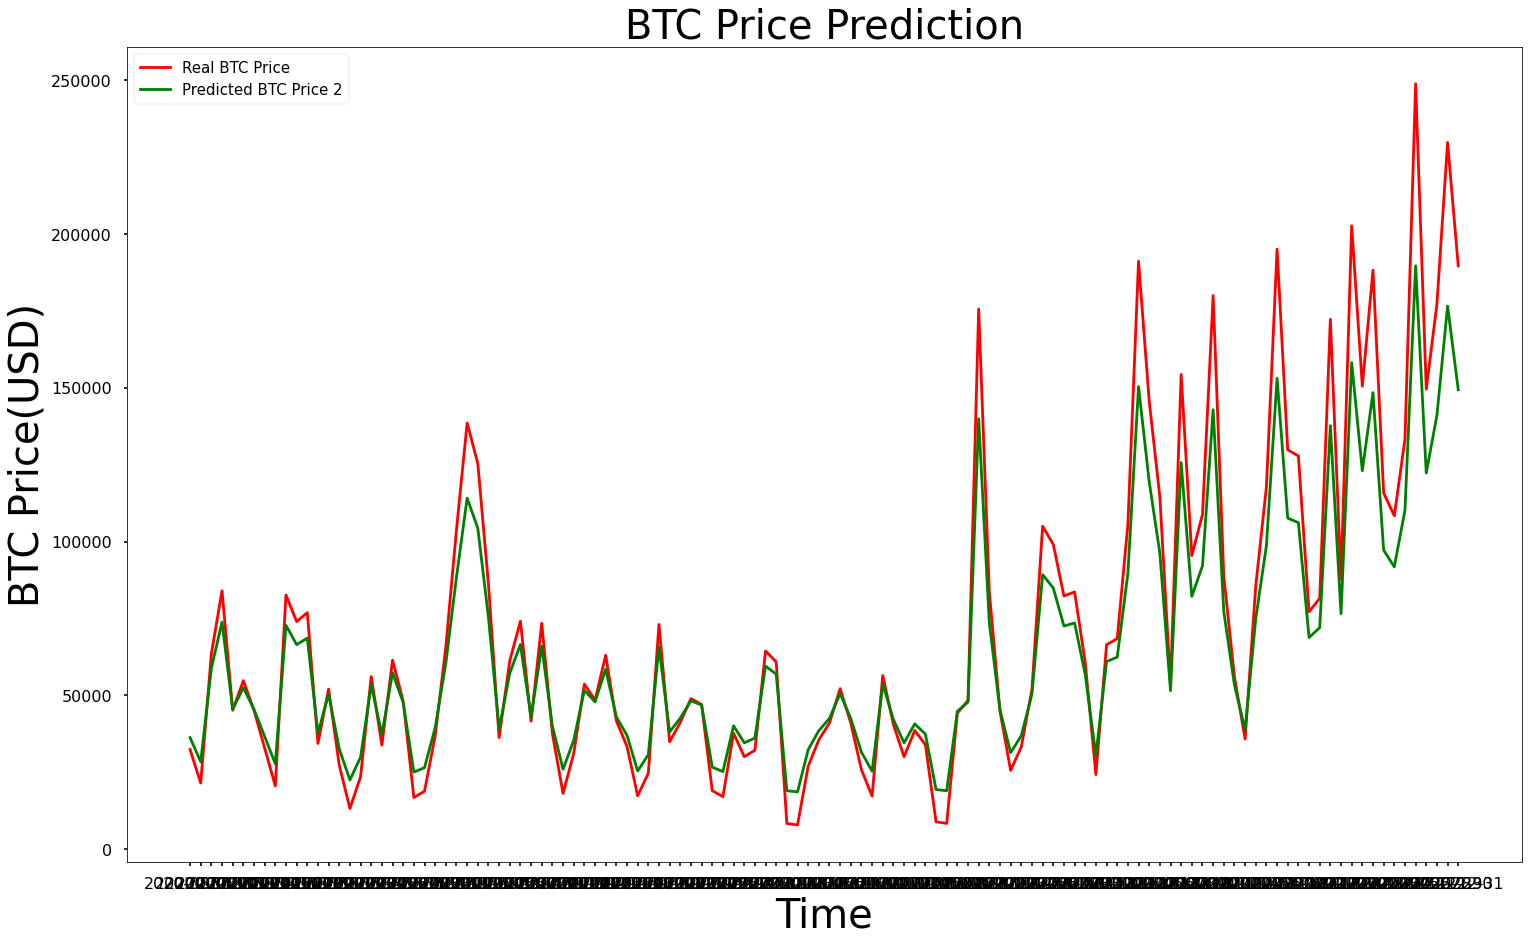

In [23]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test.reset_index()["date_only"], test.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price2, color = 'green', label = 'Predicted BTC Price 2')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

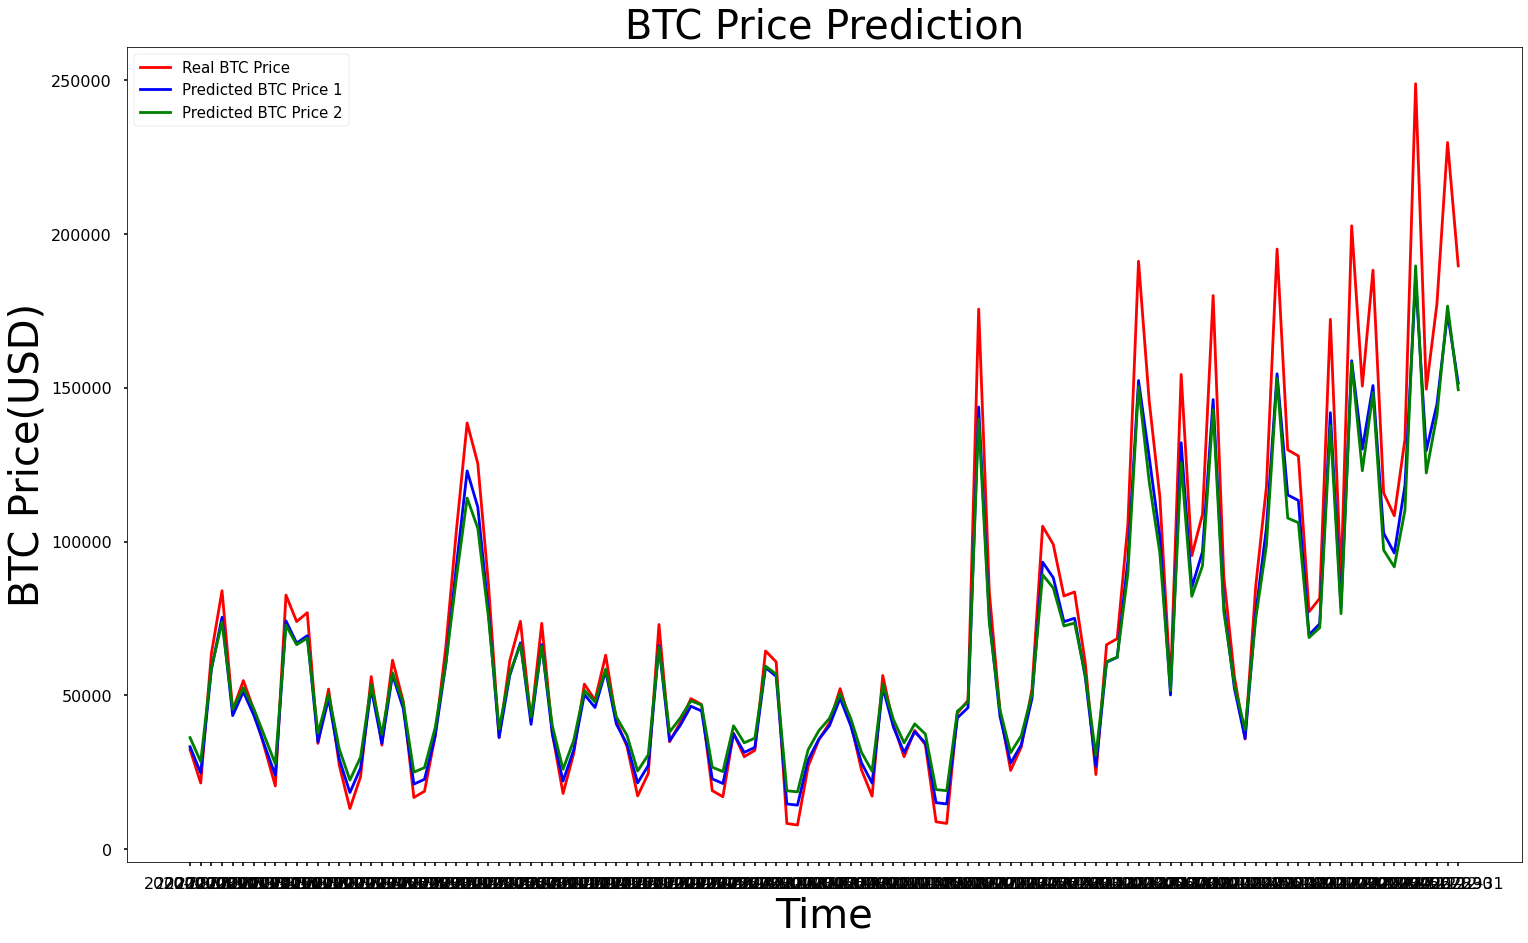

In [24]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test.reset_index()["date_only"], test.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price 1')
plt.plot(predicted_BTC_price2, color = 'green', label = 'Predicted BTC Price 2')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

**Observations:** We can see similar predictions, more like both are overlapping each other, however model 1's predictions seems to be better than model 2's predictions. Let's try to update the train/test split to 60 days for more training data.

**Model 3**

<h3 style="color:brown">Train/Test Split</h3>

In [25]:
# using prediction as 2 months, we're using 60 for train/test split

prediction_days = len(Price)-60

train_new = Price.iloc[:prediction_days]
test_new = Price.iloc[prediction_days:]

In [26]:
train_new.shape, test_new.shape

((1375, 1), (60, 1))

<h3 style="color:brown">Data Preprocessing</h3>

In [27]:
# Data preprocess

sc = MinMaxScaler()

sc.fit(train_new)

scaled_train_new = sc.transform(train_new)
scaled_test_new = sc.transform(test_new)

X_train_new = scaled_train_new[0:len(scaled_train_new)-1]
y_train_new = scaled_train_new[1:len(scaled_train_new)]

X_test_new = scaled_train[0:len(scaled_test_new)-1]
y_test_new = scaled_train[1:len(scaled_test_new)]

In [28]:
early_stop = EarlyStopping(monitor='loss',patience=2)

In [29]:
%%time

regressor3 = Sequential()

# Adding the input layer and the LSTM layer
regressor3.add(LSTM(units = 256, activation = 'relu', input_shape = (None, 1)))

# Adding the output layer
regressor3.add(Dense(units = 1))

# Compiling the RNN
regressor3.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor3.fit(X_train_new, y_train_new, batch_size = 5, epochs = 50, callbacks=[early_stop])

Epoch 1/50

275/275 [==============================] - 3s 5ms/step - loss: 0.0061

Epoch 2/50

275/275 [==============================] - 2s 6ms/step - loss: 0.0036

Epoch 3/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0035

Epoch 4/50

275/275 [==============================] - 2s 6ms/step - loss: 0.0035

Epoch 5/50

275/275 [==============================] - 1s 4ms/step - loss: 0.0035

Epoch 6/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0035

Epoch 7/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0035

Epoch 8/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0035

Epoch 9/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0034

Epoch 10/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0034

Epoch 11/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0034

Epoch 12/50

275/275 [==============================] - 1s 5ms/step - loss: 0.0034

E

<AxesSubplot:>

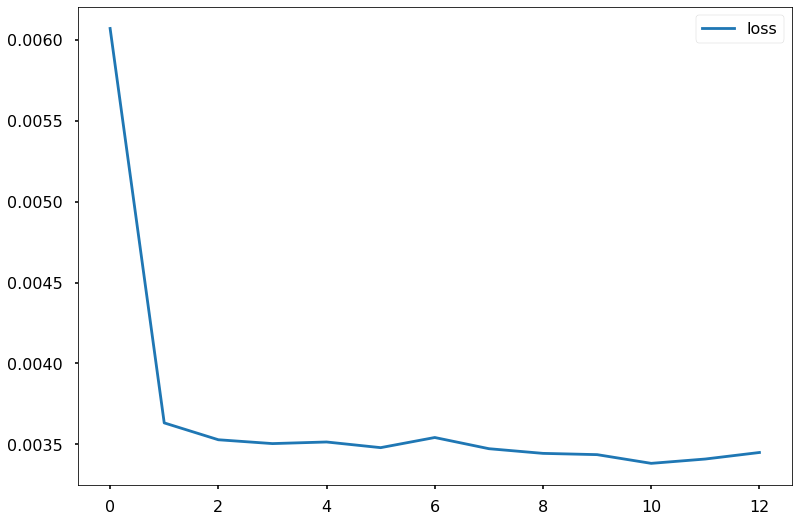

In [30]:
losses = pd.DataFrame(regressor3.history.history)
losses.plot()

<h3 style="color:brown">Testing the Model</h3>

In [31]:
predicted_BTC_price3 = regressor3.predict(scaled_test_new)

predicted_BTC_price3 = sc.inverse_transform(predicted_BTC_price3)

2/2 [==============================] - 0s 741us/step


In [32]:
test_new["Predictions_Model3"] = predicted_BTC_price3
test_new

,Volume USD,Predictions_Model3
date_only,,
2020-10-07,41019.068902,41654.910156
2020-10-08,52156.453288,50497.703125
2020-10-09,40955.854906,41604.710938
2020-10-10,25768.742410,29542.531250
2020-10-11,17193.442415,22729.673828
2020-10-12,56435.815564,53894.750000
2020-10-13,40477.652763,41224.972656
2020-10-14,30009.325910,32911.023438
2020-10-15,38554.395137,39697.679688


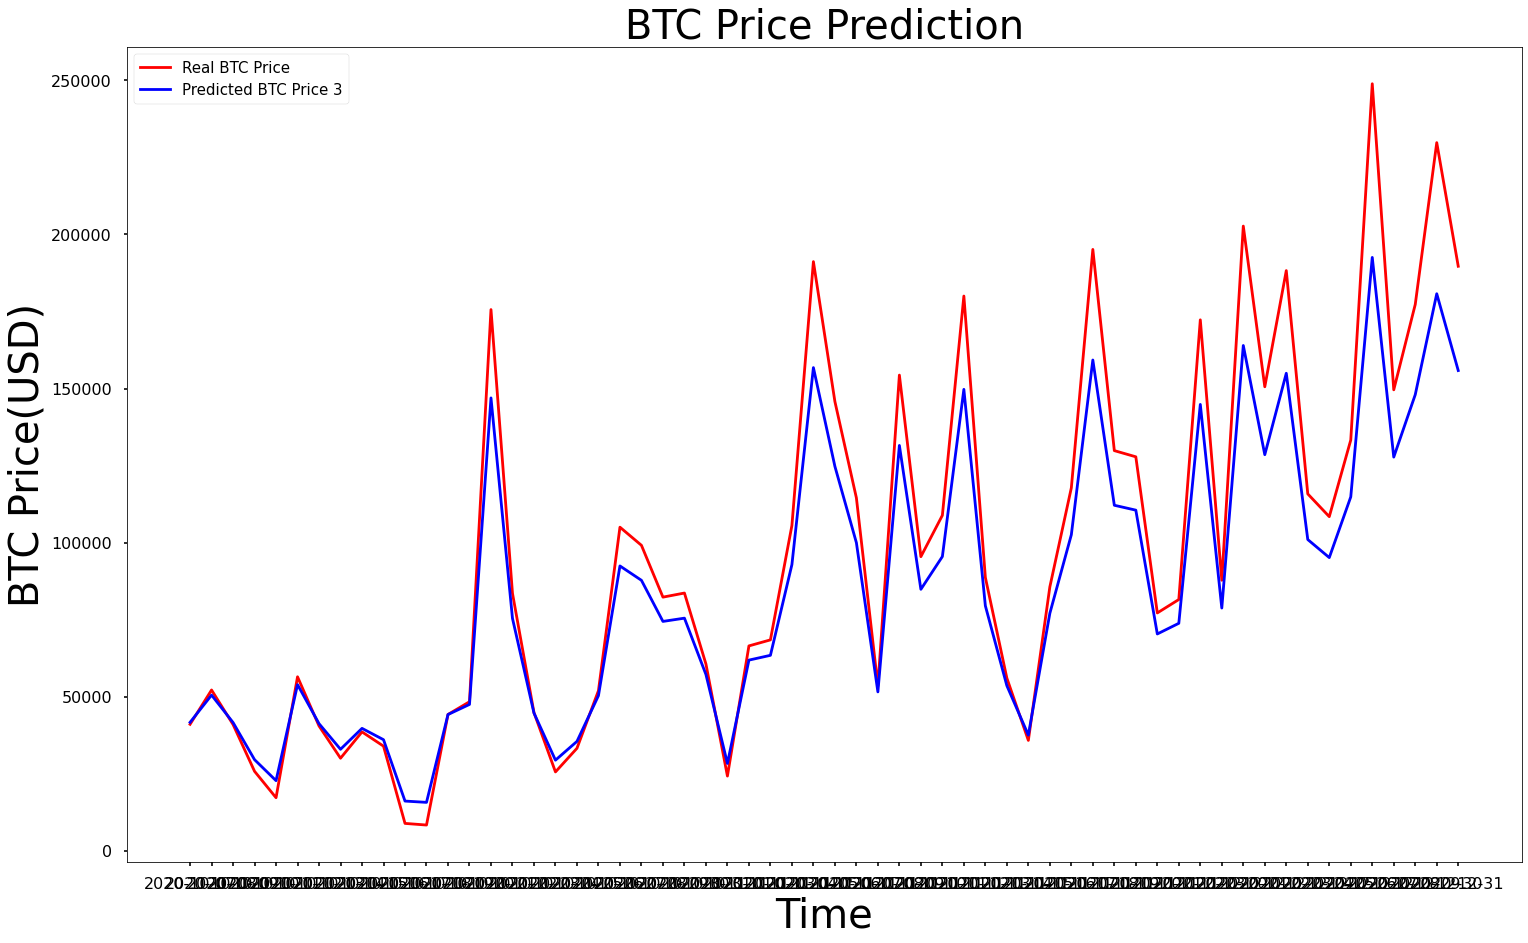

In [33]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test_new.reset_index()["date_only"], test_new.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price3, color = 'blue', label = 'Predicted BTC Price 3')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [34]:
all_test_res = test.join(test_new["Predictions_Model3"], on="date_only", how="left")
all_test_res

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model3
date_only,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,NaN
2020-08-09,21463.778842,24744.744141,28390.945312,NaN
2020-08-10,63531.091502,58332.558594,58838.808594,NaN
2020-08-11,84009.668974,75388.945312,73804.460938,NaN
2020-08-12,45127.330317,43394.839844,45469.636719,NaN
...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,192540.828125
2020-12-28,149571.375912,129557.328125,122308.351562,127737.351562
2020-12-29,177284.799030,144677.656250,141059.156250,147999.437500


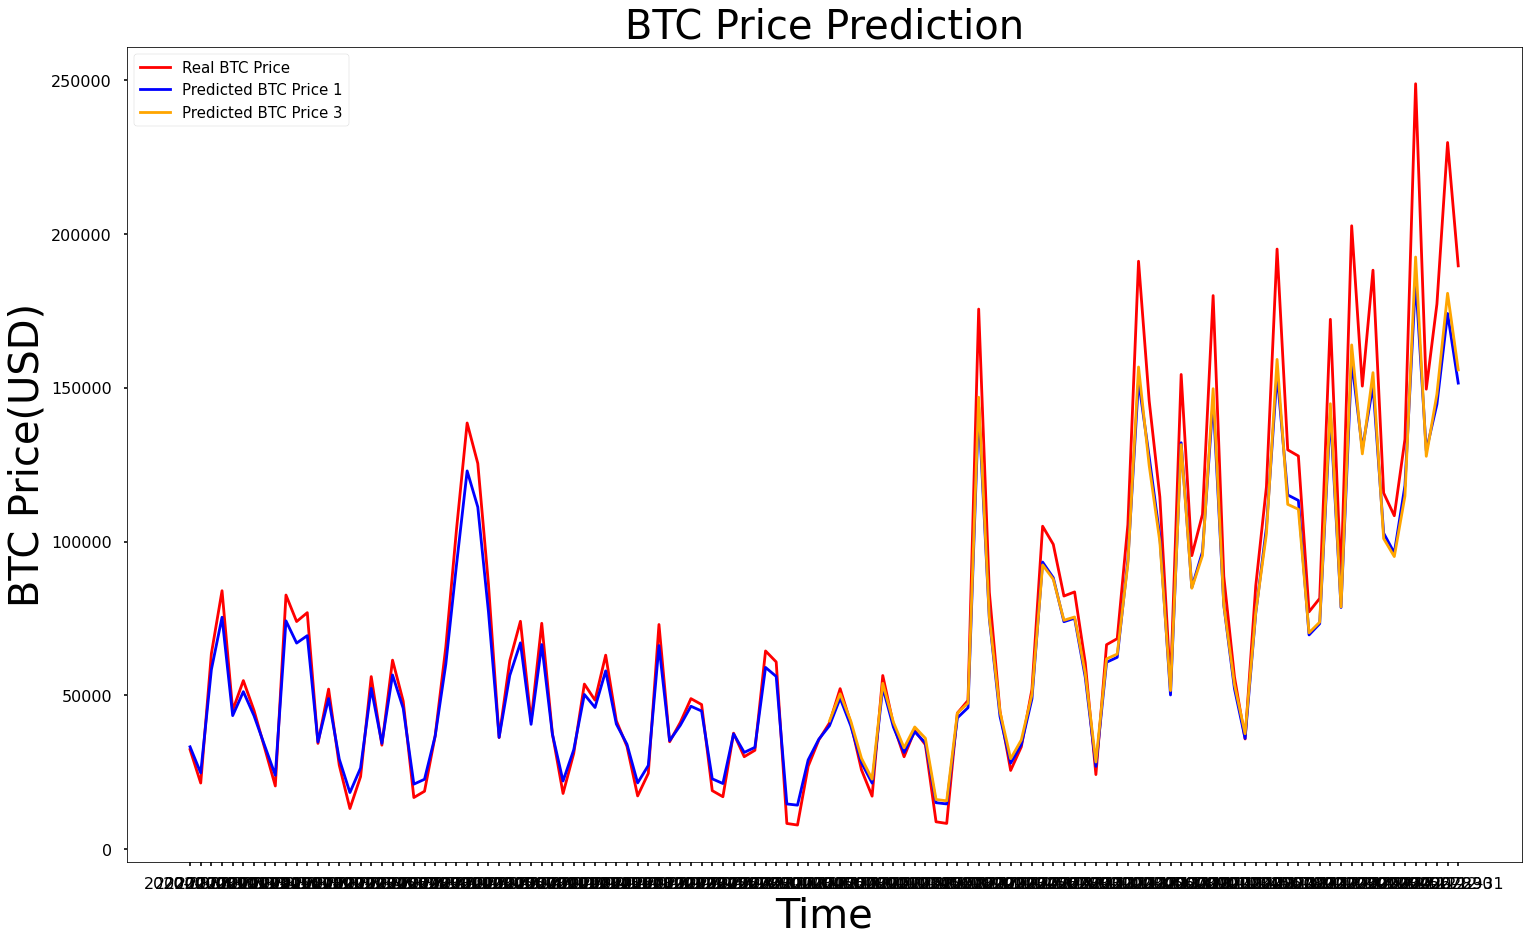

In [35]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(all_test_res.reset_index()["date_only"], all_test_res.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(all_test_res.Predictions_Model1, color = 'blue', label = 'Predicted BTC Price 1')
plt.plot(all_test_res.Predictions_Model3, color = 'orange', label = 'Predicted BTC Price 3')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

**Observations:** By plotting the model 3 predictions with model 1's (which was better than model 2's predictions), we can observe that model 1 is quite similar to actual values throughout, but model 3 is better towards the end, which is understandable since the test data is for the end part of the whole 120 days.

<h3 style="color:brown">Trying Out Keras-Tuner for hyper-parameter tuning</h3>

In [81]:
def model_build(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(units = 256, activation = 'relu', input_shape = (None,1)))
    for i in range(hp.Int("num_layers", 1, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                                            activation='relu'))
    model.add(layers.Dense(1, activation='relu'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])
    return model

**Initializing Tuner**

In [82]:
tuner = RandomSearch(
    model_build,
    objective='val_mean_squared_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Bit_Coin_Price_Prediction')

In [83]:
tuner.search_space_summary()

Search space summary

Default search space size: 3

num_layers (Int)

{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 20, 'step': 1, 'sampling': 'linear'}

units_0 (Int)

{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}

learning_rate (Choice)

{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


**Running Tuner**

In [84]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 32s]

val_mean_squared_error: 0.0018197661847807467



Best val_mean_squared_error So Far: 0.00017503355047665536

Total elapsed time: 00h 01m 50s

INFO:tensorflow:Oracle triggered exit


**Results from Tuner**

In [85]:
tuner.results_summary()

Results summary

Results in project\Bit_Coin_Price_Prediction

Showing 10 best trials


Trial summary

Hyperparameters:

num_layers: 7

units_0: 512

learning_rate: 0.01

units_1: 256

units_2: 512

units_3: 416

units_4: 192

units_5: 32

units_6: 128

units_7: 512

units_8: 128

units_9: 416

units_10: 416

units_11: 512

units_12: 96

units_13: 416

units_14: 288

Score: 0.00017503355047665536

Trial summary

Hyperparameters:

num_layers: 15

units_0: 32

learning_rate: 0.001

units_1: 32

units_2: 32

units_3: 32

units_4: 32

units_5: 32

units_6: 32

units_7: 32

units_8: 32

units_9: 32

units_10: 32

units_11: 32

units_12: 32

units_13: 32

units_14: 32

Score: 0.00046582400682382286

Trial summary

Hyperparameters:

num_layers: 2

units_0: 160

learning_rate: 0.0001

units_1: 480

units_2: 128

units_3: 128

units_4: 384

units_5: 448

units_6: 32

units_7: 192

units_8: 96

units_9: 128

units_10: 224

units_11: 192

units_12: 224

units_13: 320

units_14: 320

Score: 0.0012

**Model 4** : Using tuner's best results

In [182]:
regressor4 = keras.Sequential()
regressor4.add(layers.LSTM(units = 256, activation = 'relu', input_shape = (None,1)))

regressor4.add(layers.Dense(units=512,activation='relu'))
regressor4.add(layers.Dense(units=256,activation='relu'))
regressor4.add(layers.Dense(units=512,activation='relu'))
regressor4.add(layers.Dense(units=416,activation='relu'))
regressor4.add(layers.Dense(units=192,activation='relu'))
regressor4.add(layers.Dense(units=32,activation='relu'))
regressor4.add(layers.Dense(units=128,activation='relu'))
regressor4.add(layers.Dense(units=512,activation='relu'))
regressor4.add(layers.Dense(units=128,activation='relu'))
regressor4.add(layers.Dense(units=416,activation='relu'))
regressor4.add(layers.Dense(units=512,activation='relu'))
regressor4.add(layers.Dense(units=96,activation='relu'))
regressor4.add(layers.Dense(units=416,activation='relu'))
regressor4.add(layers.Dense(units=512,activation='relu'))
regressor4.add(layers.Dense(units=96,activation='relu'))
regressor4.add(layers.Dense(units=416,activation='relu'))
regressor4.add(layers.Dense(units=288,activation='relu'))


regressor4.add(layers.Dense(1, activation='tanh'))
regressor4.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='mean_squared_error',
        metrics="mse")

In [183]:
# Fitting the RNN to the Training set
regressor4.fit(X_train, y_train, batch_size = 7, epochs = 50, callbacks=[early_stop])

Epoch 1/50

188/188 [==============================] - 5s 10ms/step - loss: 0.0075 - mse: 0.0075

Epoch 2/50

188/188 [==============================] - 2s 10ms/step - loss: 0.0042 - mse: 0.0042

Epoch 3/50

188/188 [==============================] - 2s 10ms/step - loss: 0.0037 - mse: 0.0037

Epoch 4/50

188/188 [==============================] - 2s 10ms/step - loss: 0.0039 - mse: 0.0039

Epoch 5/50

188/188 [==============================] - 2s 10ms/step - loss: 0.0041 - mse: 0.0041


<AxesSubplot:>

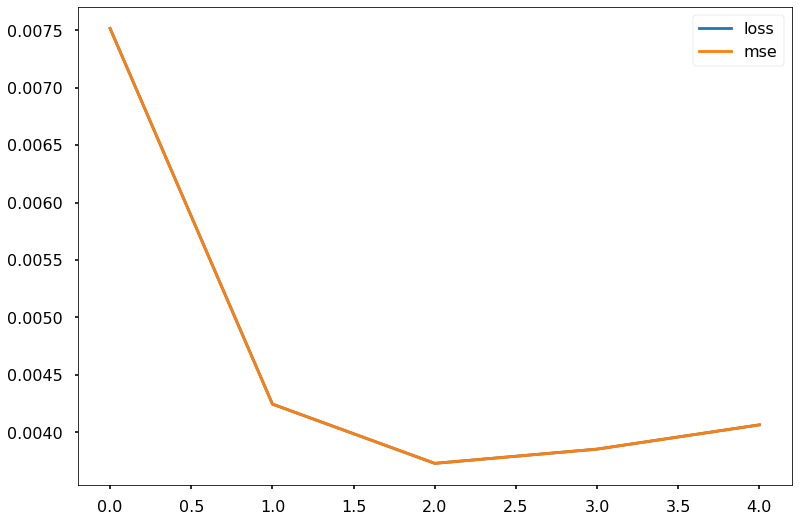

In [184]:
losses = pd.DataFrame(regressor4.history.history)
losses.plot()

<h3 style="color:brown">Testing the Model</h3>

In [185]:
predicted_BTC_price4 = regressor4.predict(scaled_test)

predicted_BTC_price4 = sc.inverse_transform(predicted_BTC_price4)

4/4 [==============================] - 0s 6ms/step


In [186]:
test["Predictions_Model4"] = predicted_BTC_price4
test

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model4,Predictions_Model5
date_only,,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,38161.617188,34700.492188
2020-08-09,21463.778842,24744.744141,28390.945312,25025.873047,26598.027344
2020-08-10,63531.091502,58332.558594,58838.808594,70827.890625,57087.679688
2020-08-11,84009.668974,75388.945312,73804.460938,92812.617188,74848.078125
2020-08-12,45127.330317,43394.839844,45469.636719,51024.675781,43451.136719
...,...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,217340.812500,179428.218750
2020-12-28,149571.375912,129557.328125,122308.351562,152995.031250,124523.304688
2020-12-29,177284.799030,144677.656250,141059.156250,172874.421875,142528.468750


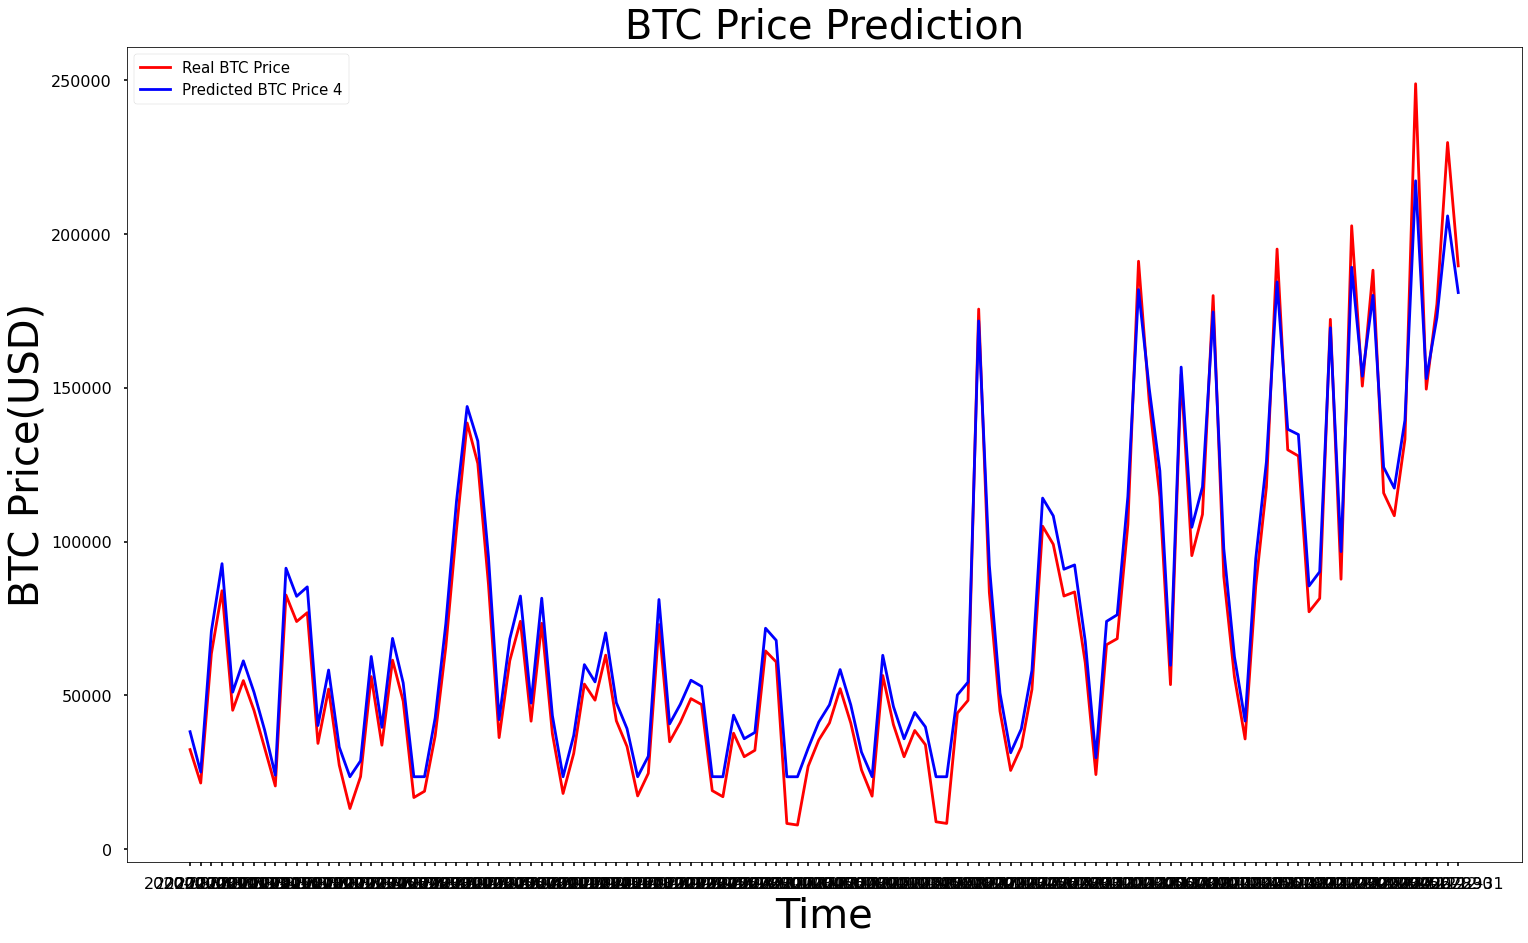

In [187]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test.reset_index()["date_only"], test.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price4, color = 'blue', label = 'Predicted BTC Price 4')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

**This is the best fit model till now**

In [188]:
all_test_res["Predictions_Model4"] = test["Predictions_Model4"]
all_test_res

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model3,Predictions_Model4,Predictions_Model5
date_only,,,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,NaN,38161.617188,34700.492188
2020-08-09,21463.778842,24744.744141,28390.945312,NaN,25025.873047,26598.027344
2020-08-10,63531.091502,58332.558594,58838.808594,NaN,70827.890625,57087.679688
2020-08-11,84009.668974,75388.945312,73804.460938,NaN,92812.617188,74848.078125
2020-08-12,45127.330317,43394.839844,45469.636719,NaN,51024.675781,43451.136719
...,...,...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,192540.828125,217340.812500,179428.218750
2020-12-28,149571.375912,129557.328125,122308.351562,127737.351562,152995.031250,124523.304688
2020-12-29,177284.799030,144677.656250,141059.156250,147999.437500,172874.421875,142528.468750


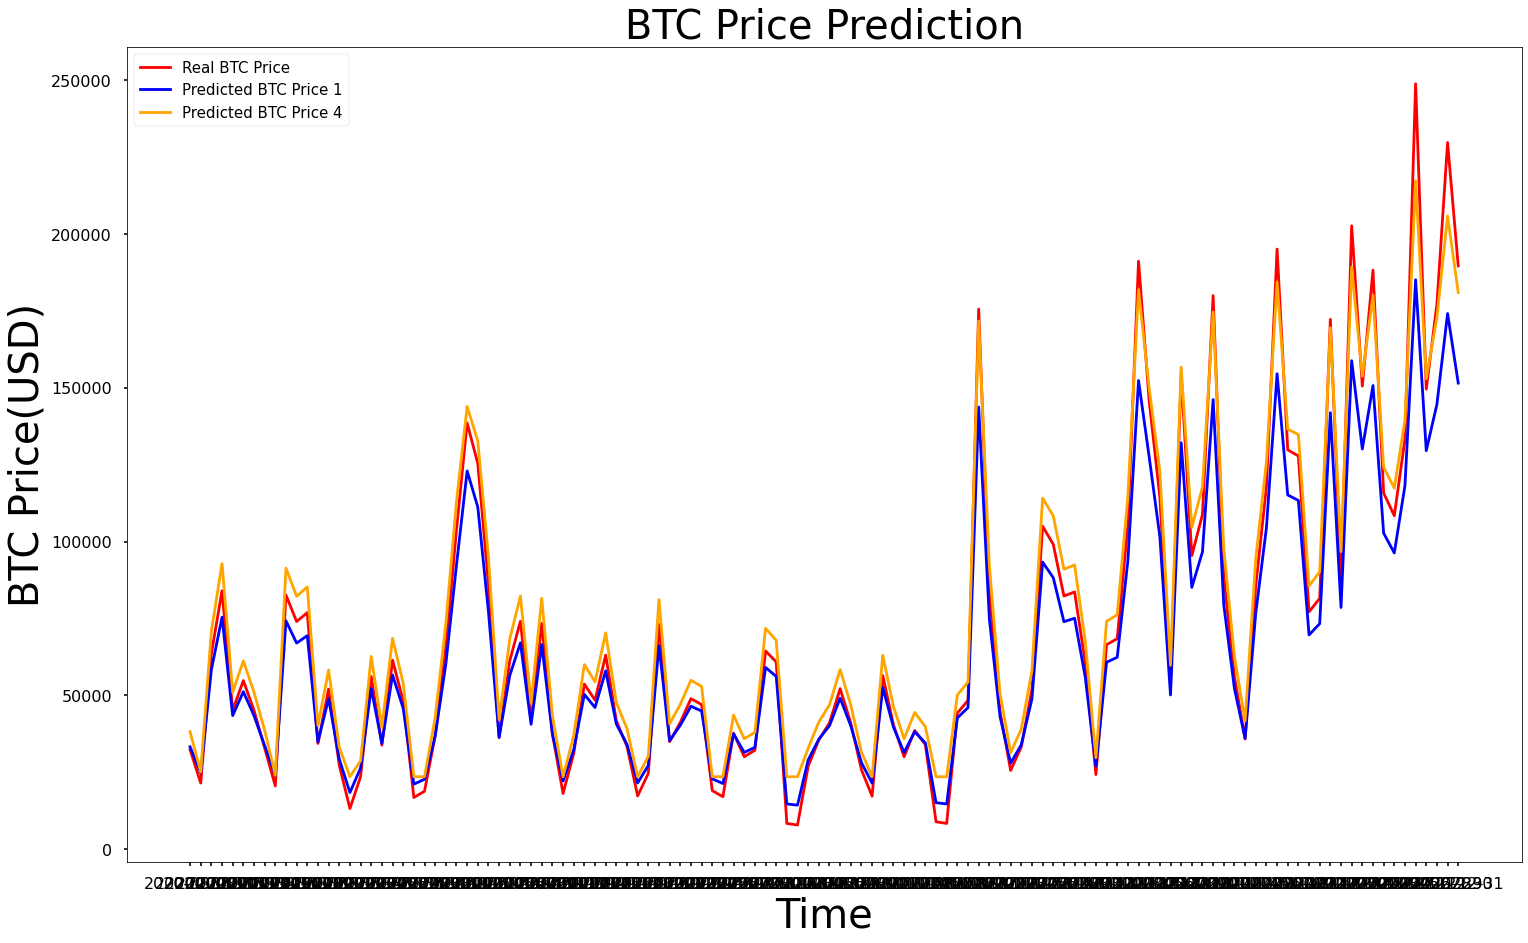

In [189]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(all_test_res.reset_index()["date_only"], all_test_res.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(all_test_res.Predictions_Model1, color = 'blue', label = 'Predicted BTC Price 1')
plt.plot(all_test_res.Predictions_Model4, color = 'orange', label = 'Predicted BTC Price 4')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

**Observations:**
We can see both the models are quite close, however model 4 is close to the actual values throughout. Although model 1's MSE is less than model 4, still in the plot we can see model 4 as the best model till now.

**Trying the second best result from keras-tuner**

**Model 5**

In [225]:
regressor5 = keras.Sequential()
regressor5.add(layers.LSTM(units = 256, activation = 'relu', input_shape = (None,1)))

regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))
regressor5.add(layers.Dense(units=32,activation='relu'))


regressor5.add(layers.Dense(1, activation='tanh'))
regressor5.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00001),
        loss='mean_squared_error',
        metrics=['mean_squared_error'])

In [226]:
# Fitting the RNN to the Training set
regressor5.fit(X_train, y_train, batch_size = 7, epochs = 50, callbacks=[early_stop])

Epoch 1/50

188/188 [==============================] - 4s 6ms/step - loss: 0.0141 - mean_squared_error: 0.0141

Epoch 2/50

188/188 [==============================] - 1s 5ms/step - loss: 0.0102 - mean_squared_error: 0.0102

Epoch 3/50

188/188 [==============================] - 1s 6ms/step - loss: 0.0085 - mean_squared_error: 0.0085

Epoch 4/50

188/188 [==============================] - 1s 6ms/step - loss: 0.0082 - mean_squared_error: 0.0082

Epoch 5/50

188/188 [==============================] - 1s 6ms/step - loss: 0.0081 - mean_squared_error: 0.0081

Epoch 6/50

188/188 [==============================] - 1s 6ms/step - loss: 0.0080 - mean_squared_error: 0.0080

Epoch 7/50

188/188 [==============================] - 1s 6ms/step - loss: 0.0079 - mean_squared_error: 0.0079

Epoch 8/50

188/188 [==============================] - 1s 6ms/step - loss: 0.0078 - mean_squared_error: 0.0078

Epoch 9/50

188/188 [==============================] - 1s 5ms/step - loss: 0.0077 - mean_squared_error: 

<AxesSubplot:>

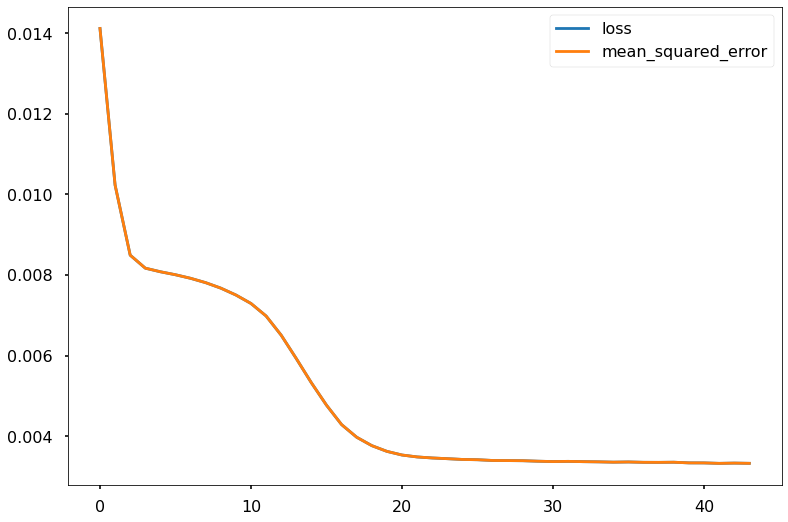

In [227]:
losses = pd.DataFrame(regressor5.history.history)
losses.plot()

<h3 style="color:brown">Testing the Model</h3>

In [228]:
predicted_BTC_price5 = regressor5.predict(scaled_test)

predicted_BTC_price5 = sc.inverse_transform(predicted_BTC_price5)

4/4 [==============================] - 0s 5ms/step


In [229]:
test["Predictions_Model5"] = predicted_BTC_price5
test

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model4,Predictions_Model5
date_only,,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,38161.617188,37608.988281
2020-08-09,21463.778842,24744.744141,28390.945312,25025.873047,28419.933594
2020-08-10,63531.091502,58332.558594,58838.808594,70827.890625,65671.085938
2020-08-11,84009.668974,75388.945312,73804.460938,92812.617188,84751.320312
2020-08-12,45127.330317,43394.839844,45469.636719,51024.675781,49096.925781
...,...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,217340.812500,185565.828125
2020-12-28,149571.375912,129557.328125,122308.351562,152995.031250,135624.734375
2020-12-29,177284.799030,144677.656250,141059.156250,172874.421875,154336.281250


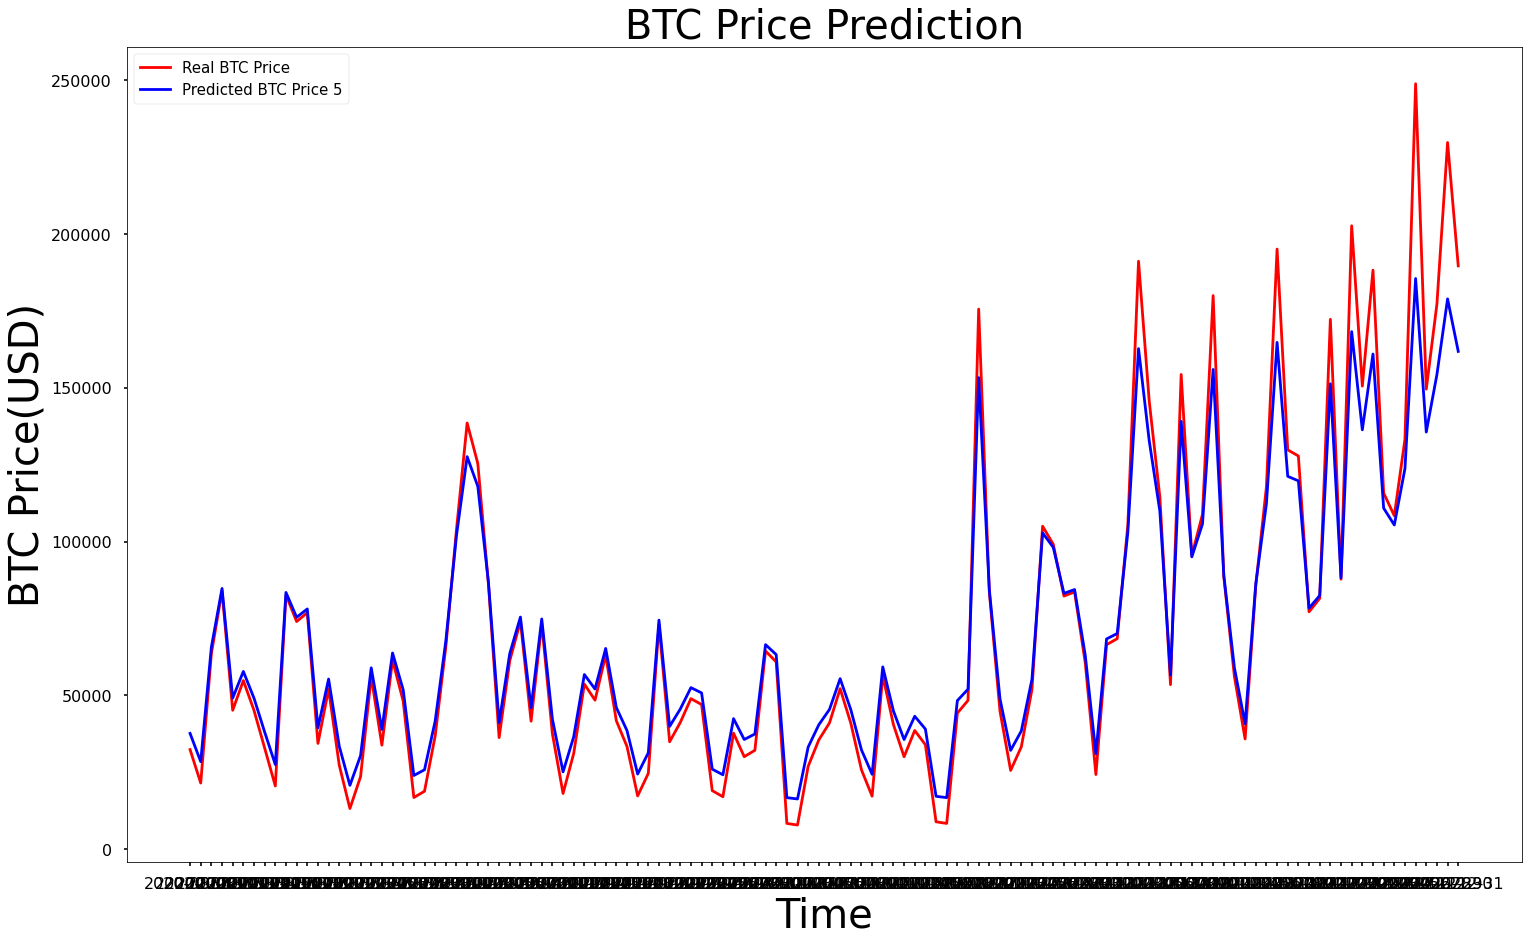

In [230]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test.reset_index()["date_only"], test.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price5, color = 'blue', label = 'Predicted BTC Price 5')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [231]:
all_test_res["Predictions_Model5"] = test["Predictions_Model5"]
all_test_res

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model3,Predictions_Model4,Predictions_Model5
date_only,,,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,NaN,38161.617188,37608.988281
2020-08-09,21463.778842,24744.744141,28390.945312,NaN,25025.873047,28419.933594
2020-08-10,63531.091502,58332.558594,58838.808594,NaN,70827.890625,65671.085938
2020-08-11,84009.668974,75388.945312,73804.460938,NaN,92812.617188,84751.320312
2020-08-12,45127.330317,43394.839844,45469.636719,NaN,51024.675781,49096.925781
...,...,...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,192540.828125,217340.812500,185565.828125
2020-12-28,149571.375912,129557.328125,122308.351562,127737.351562,152995.031250,135624.734375
2020-12-29,177284.799030,144677.656250,141059.156250,147999.437500,172874.421875,154336.281250


**Comparision with the best model till now**

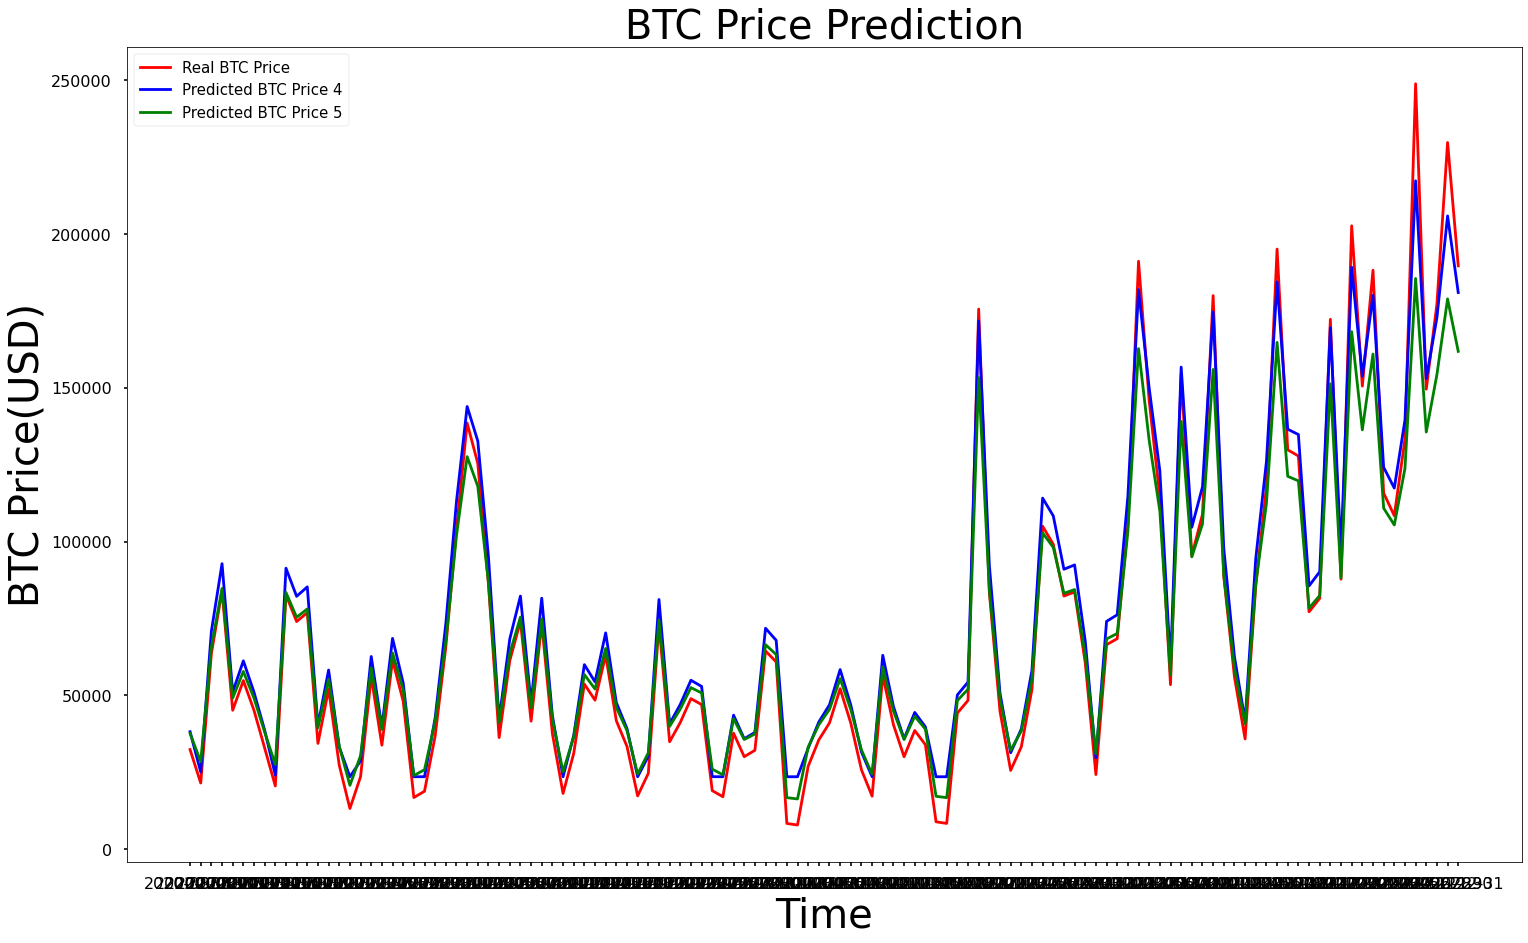

In [267]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(all_test_res.reset_index()["date_only"], all_test_res.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(all_test_res.Predictions_Model4, color = 'blue', label = 'Predicted BTC Price 4')
plt.plot(all_test_res.Predictions_Model5, color = 'green', label = 'Predicted BTC Price 5')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

**Observations:**
We can see both the models are quite close, however model 4 is close to the actual values throughout. Although model 5's MSE is less than model 4, still in the plot we can see model 4 as the winning model.

**Model 6**

In [247]:
regressor6 = keras.Sequential()
regressor6.add(layers.LSTM(units = 256, activation = 'relu', input_shape = (None,1)))

regressor6.add(layers.Dense(units=512,activation='relu'))
regressor6.add(layers.Dense(units=256,activation='relu'))
regressor6.add(layers.Dense(units=512,activation='relu'))
regressor6.add(layers.Dense(units=416,activation='relu'))
regressor6.add(layers.Dense(units=192,activation='relu'))
regressor6.add(layers.Dense(units=32,activation='relu'))
regressor6.add(layers.Dense(units=128,activation='relu'))
regressor6.add(layers.Dense(units=512,activation='relu'))
regressor6.add(layers.Dense(units=128,activation='relu'))
regressor6.add(layers.Dense(units=416,activation='relu'))
regressor6.add(layers.Dense(units=512,activation='relu'))
regressor6.add(layers.Dense(units=96,activation='relu'))
regressor6.add(layers.Dense(units=416,activation='relu'))
regressor6.add(layers.Dense(units=512,activation='relu'))
regressor6.add(layers.Dense(units=96,activation='relu'))
regressor6.add(layers.Dense(units=416,activation='relu'))
regressor6.add(layers.Dense(units=288,activation='relu'))


regressor6.add(layers.Dense(1, activation='tanh'))
regressor6.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.00001),
        loss='mean_squared_error',
        metrics="mse")

In [258]:
# Fitting the RNN to the Training set
regressor6.fit(X_train, y_train, batch_size = 10, epochs = 50, callbacks=[early_stop])

Epoch 1/50

132/132 [==============================] - 1s 10ms/step - loss: 0.0034 - mse: 0.0034

Epoch 2/50

132/132 [==============================] - 1s 10ms/step - loss: 0.0033 - mse: 0.0033

Epoch 3/50

132/132 [==============================] - 1s 9ms/step - loss: 0.0033 - mse: 0.0033

Epoch 4/50

132/132 [==============================] - 1s 9ms/step - loss: 0.0033 - mse: 0.0033

Epoch 5/50

132/132 [==============================] - 1s 10ms/step - loss: 0.0033 - mse: 0.0033

Epoch 6/50

132/132 [==============================] - 1s 9ms/step - loss: 0.0033 - mse: 0.0033

Epoch 7/50

132/132 [==============================] - 1s 9ms/step - loss: 0.0033 - mse: 0.0033


<AxesSubplot:>

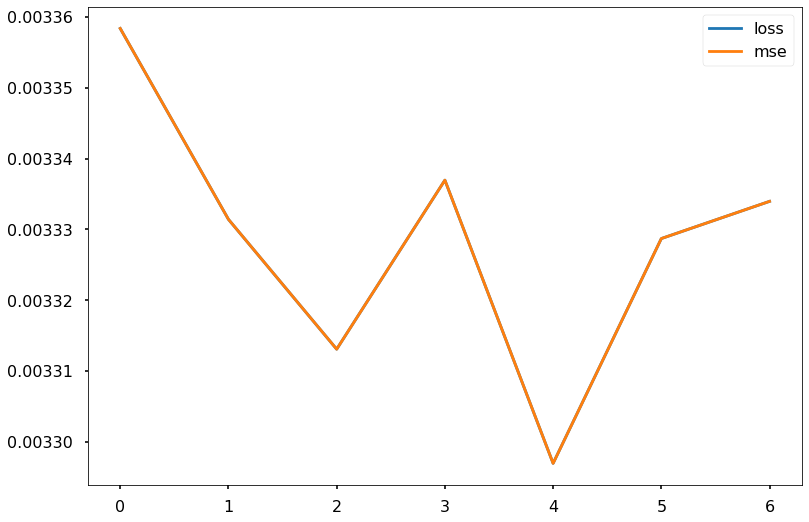

In [259]:
losses = pd.DataFrame(regressor6.history.history)
losses.plot()

<h3 style="color:brown">Testing the Model</h3>

In [260]:
predicted_BTC_price6 = regressor6.predict(scaled_test)

predicted_BTC_price6 = sc.inverse_transform(predicted_BTC_price6)

4/4 [==============================] - 0s 4ms/step


In [261]:
test["Predictions_Model6"] = predicted_BTC_price6
test

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model4,Predictions_Model5,Predictions_Model6
date_only,,,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,38161.617188,37608.988281,36647.582031
2020-08-09,21463.778842,24744.744141,28390.945312,25025.873047,28419.933594,26435.185547
2020-08-10,63531.091502,58332.558594,58838.808594,70827.890625,65671.085938,61622.976562
2020-08-11,84009.668974,75388.945312,73804.460938,92812.617188,84751.320312,82168.359375
2020-08-12,45127.330317,43394.839844,45469.636719,51024.675781,49096.925781,46289.878906
...,...,...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,217340.812500,185565.828125,197191.437500
2020-12-28,149571.375912,129557.328125,122308.351562,152995.031250,135624.734375,132846.062500
2020-12-29,177284.799030,144677.656250,141059.156250,172874.421875,154336.281250,153117.984375


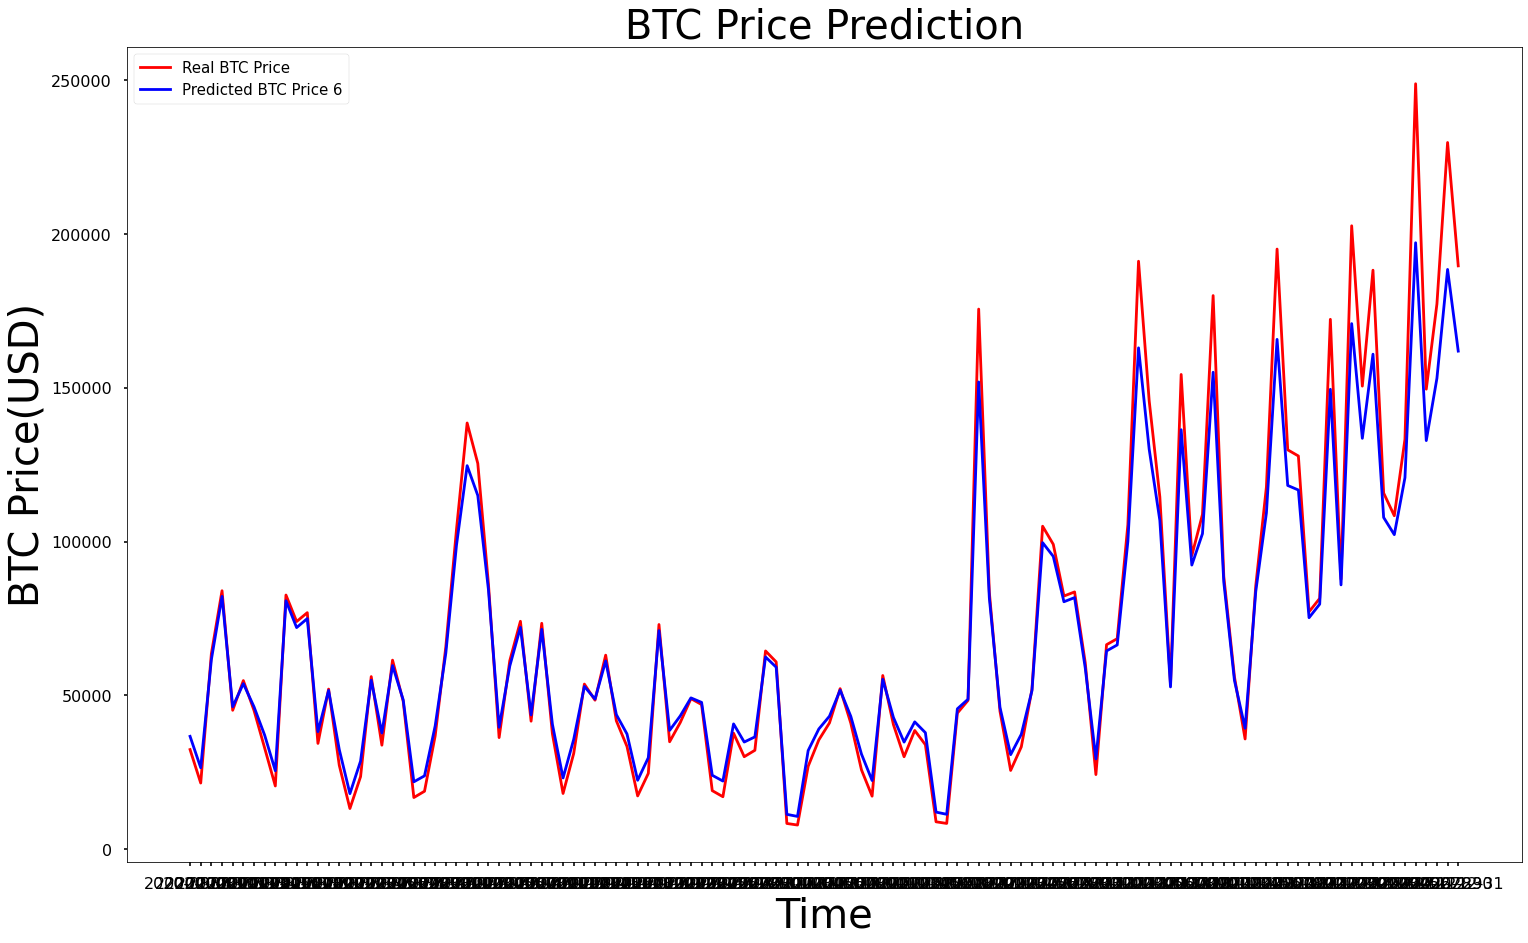

In [262]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(test.reset_index()["date_only"], test.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price6, color = 'blue', label = 'Predicted BTC Price 6')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

In [264]:
all_test_res["Predictions_Model6"] = test["Predictions_Model6"]
all_test_res

,Volume USD,Predictions_Model1,Predictions_Model2,Predictions_Model3,Predictions_Model4,Predictions_Model5,Predictions_Model6
date_only,,,,,,,
2020-08-08,32350.849036,33246.507812,36232.921875,NaN,38161.617188,37608.988281,36647.582031
2020-08-09,21463.778842,24744.744141,28390.945312,NaN,25025.873047,28419.933594,26435.185547
2020-08-10,63531.091502,58332.558594,58838.808594,NaN,70827.890625,65671.085938,61622.976562
2020-08-11,84009.668974,75388.945312,73804.460938,NaN,92812.617188,84751.320312,82168.359375
2020-08-12,45127.330317,43394.839844,45469.636719,NaN,51024.675781,49096.925781,46289.878906
...,...,...,...,...,...,...,...
2020-12-27,248901.009642,185146.812500,189675.531250,192540.828125,217340.812500,185565.828125,197191.437500
2020-12-28,149571.375912,129557.328125,122308.351562,127737.351562,152995.031250,135624.734375,132846.062500
2020-12-29,177284.799030,144677.656250,141059.156250,147999.437500,172874.421875,154336.281250,153117.984375


**Comparision with the best model**

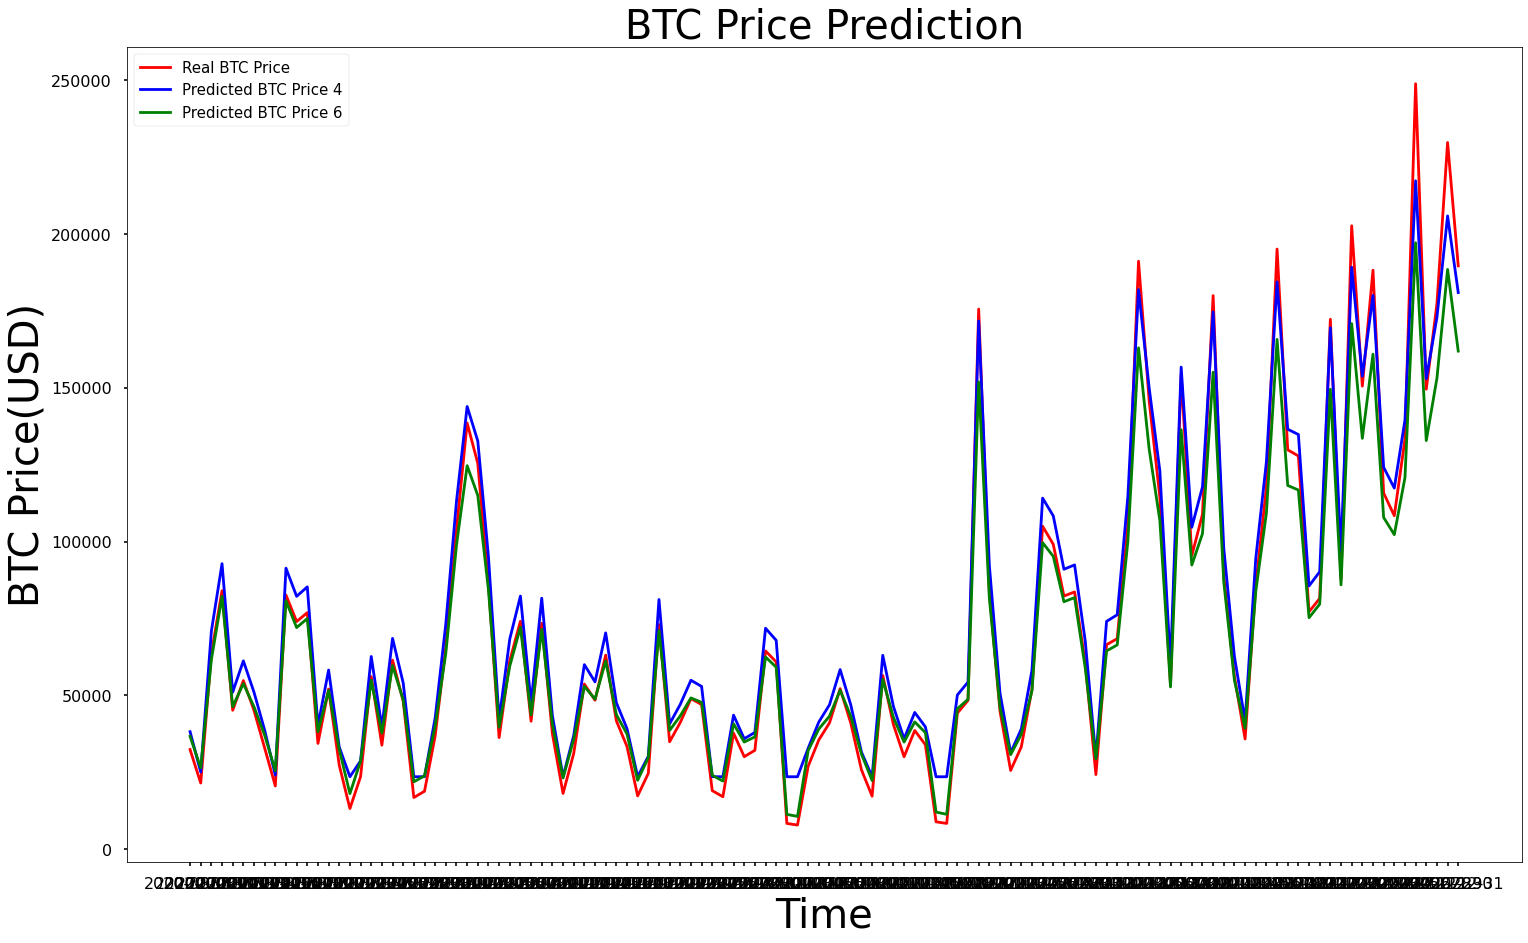

In [266]:
# Visualising the results
plt.figure(figsize=(25,15), facecolor='w', edgecolor='k')
plt.plot(all_test_res.reset_index()["date_only"], all_test_res.reset_index()["Volume USD"], color = 'red', label = 'Real BTC Price')
plt.plot(all_test_res.Predictions_Model4, color = 'blue', label = 'Predicted BTC Price 4')
plt.plot(all_test_res.Predictions_Model6, color = 'green', label = 'Predicted BTC Price 6')
plt.title('BTC Price Prediction', fontsize=40)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 15})
plt.show()

<h3 style="color:brown">Best Model</h3>

After 6 iterations using different techniques/methods:
1. We can observe that mode 6 is the most close to the low values, whereas model 4 is close to all the high values.
2. However, model 4 is close throughout the timeline. 

Hence, `model 4 is the best model`.